# Create components in the TF coil group

The "TF coil group" is just a convention used in this package. It contains:
- The superconductor component (PFCoilMagnet)
- The thermal insulation component (PFCoilInsulation)
- The case/structure body component (PFCoilCase)

In the future some more versatility will be added:
- Toroidal and poloidal thicknesses can be different

In [1]:
import openmc
import tokamak_radiation_environment as tre
import matplotlib.pyplot as plt

### Disclaimer 

Leghts are in [cm]

All the components proposed here are built with the [openmc.model.Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class of openmc. It is then possible to directly use that class for more versatility already.

The [openmc.model.Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class requires a list of points coordinates that will be connected by lines. Coordinates are given by a couple of floating numbers and can refer to any of the 'xy', 'xz', 'yz' or 'rz' planes. The polygon gets then 'extruded' on the direction perpendicular to the reference plane for an undefined extension. In the case of 'rz' plane the extrusion is revolved around the z plane which is helpful in order to design toroidal geometries.

In [2]:
# import materials
ss316L = tre.materials.ss316L
windingpack = tre.materials.windingpack
fiberglass = tre.materials.fiberglass

## Component objects

All the components have a "angle" argument that allows the user build just a slice of the tokamak using cutter planes perpendicular to the 'xy' plane. The angle must be a tuple of two angles defined in degrees.

The TFCoilMagnet component needs the nodes coordinates (in 'rz' plane by default) for the magnet inner boundary. The outer buoundary will be given by offsetting those nodes outwards according to the magnet thickness. All the other components take the magnet nodes and offset them autwards according to their thickness provided by the user.

We here provide an easy example with the ARC-class nodes.

In [3]:
tf_nodes = (
    [578, 0],
    [576, 32],
    [567, 71],
    [524, 220],
    [443, 314],
    [352, 373],
    [259, 381],
    [167, 362],
    [107, 302],
    [107, -302],
    [167, -362],
    [259, -381],
    [352, -373],
    [443, -314],
    [524, -220],
    [567, -71],
    [576, -32]
)

#### Magnet component

It is possible to rotate the magnet according to the "rotation_angle" argument. It will be in degrees and can be rotated counterclockwise around the z-axis.

In [4]:
tf_magnet = tre.components.TFCoilMagnet(inner_nodes=tf_nodes, thickness=30, material=windingpack, angle=None, rotation_angle=0)

In OpenMC with constructive solid geometry every body has its surfaces, its region and its cell. With 'tre' it is possible to extract all of them. Cells being the most important for the simulation.

In [5]:
print(f'Surfaces: {tf_magnet.surfaces}')
print(f'Region: {tf_magnet.region}')
print(f'Cell: {tf_magnet.cell}')

Surfaces: (<Polygon at 0x7f04d037b070>, <Polygon at 0x7f04d0248550>, Surface
	ID             =	101
	Name           =	
	Type           =	plane
	Boundary       =	transmission
	Coefficients   
a               =	0.0
b               =	1.0
c               =	0.0
d               =	-30
, Surface
	ID             =	103
	Name           =	
	Type           =	plane
	Boundary       =	transmission
	Coefficients   
a               =	0.0
b               =	1.0
c               =	0.0
d               =	30
, Surface
	ID             =	105
	Name           =	
	Type           =	plane
	Boundary       =	transmission
	Coefficients   
a               =	1.0
b               =	0.0
c               =	0.0
d               =	0
)
Region: (~((106 ((107 108) | -108) ((109 -110) | 110) ((111 -112) | 112) (-113 114) (-115 116) (-117 -118) ((119 120) | -120) (-121 -122) (-123 -124) (-125 -126) (-127 128) (-129 130) (-131 132) (-133 134) (-135 -136) (-137 -138))) ((277 ((278 279) | -279) ((280 -281) | 281) ((282 -283) | 283) (-284 

#### Insulation component


The insulation uses the same magnet's nodes from which it adds the insulation thickness in order to find the outer insulation surface. It then requires the magnet component as argument in order to extract the nodes.

In [6]:
insulation = tre.components.TFCoilInsulation(tf_coil_magnet=tf_magnet, thickness=10, material=fiberglass, angle=None)

#### Case component
The case uses the same magnet's nodes from which it adds the insulation thickness and the case thickness in order to find the outer insulation surface. It then requires the magnet component and the insulation component as arguments in order to extract nodes and thickness.

In [7]:
case = tre.components.TFCoilCase(tf_coil_magnet=tf_magnet, thickness=20, material=ss316L, tf_coil_insulation=insulation, angle=None)

## TF coil group function
The TF coil group function helps to generate all the component objects in the PF coil in just one call. It can used as alternative to the workflow that builds component by component presented just above.
It is necessary to provide:
- The magnet componet nodes
- The magnet component material
- The insulation component thickness
- The insulation component material
- The case component thickness
- The case component material

In [8]:
magnet, insulation, case = tre.components.tfcoil_group(
    magnet_inner_nodes=tf_nodes, magnet_thickness=30, magnet_material=windingpack,
    insulation_thickness=10, insulation_material=fiberglass,
    case_thickness=20, case_material=ss316L,
    angle=None, rotation_angle=0)

### Collect the cells in openmc geometry

In [9]:
root = [tf_magnet.cell, insulation.cell, case.cell]

geometry = openmc.Geometry(root=root)

## Visualize geometry

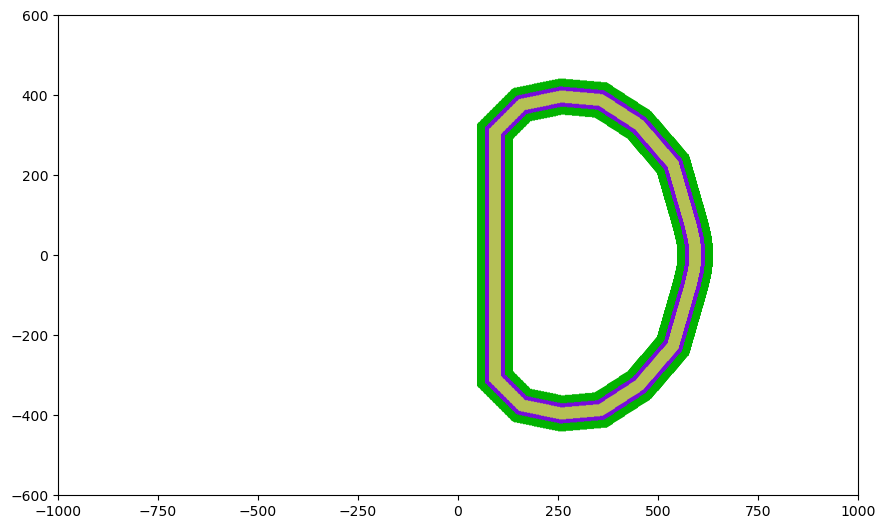

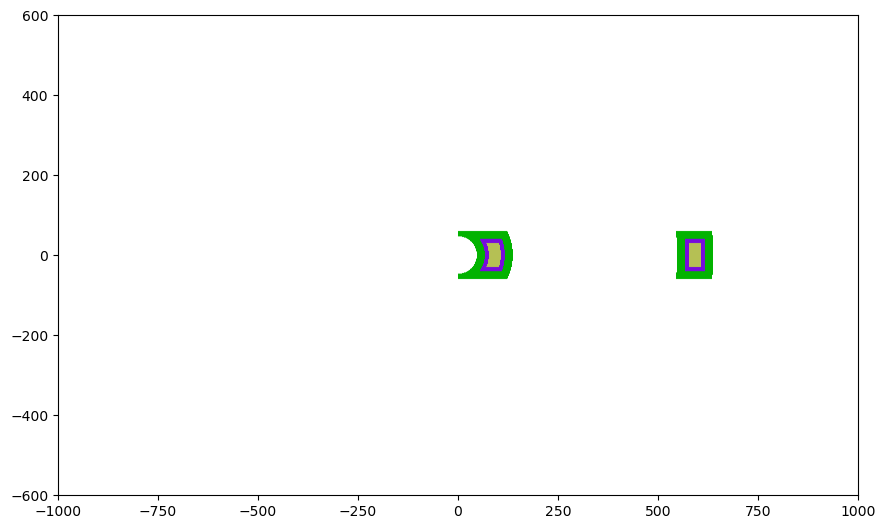

In [10]:
universe = openmc.Universe(cells=root)

universe.plot(basis='xz', width=[2000, 1200], pixels=[800, 800], color_by='cell')
plt.show()

universe.plot(basis='xy', width=[2000, 1200], pixels=[800, 800], color_by='cell')
plt.show()